In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**For the dataset used** <br>
https://www.kaggle.com/code/ashishpawar511/fake-news-classification-using-logreg-lstm/data




## Import libraries 

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 172 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=8e07732b0b5d008c20f16d7d46c017b45116c9d455cbc68bd1eeeede066223fb
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=6041cb57cf694c40afbf4346910b722c3c13d4e5d66e2036cf21da21a11c0e29
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=455571565e06024f9cc46c0d3530aaf8d10fa349192651d92e6752fe70c90da2
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow p

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 38.4 MB/s 
     |████████████████████████████████| 120 kB 73.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.7 MB/s 


In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import bert
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from google.colab import drive
import pickle
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Bidirectional, LSTM,GlobalAveragePooling1D
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/data/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/data/True.csv")

In [ ]:
def plot_confusion_matrix(cm,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          target_names=None,
                          path_file='1.svg'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_file,format='svg')
    plt.show()

In [ ]:
# To define function to find batch size for training the model
# use this function to find out the batch size
def FindBatchSize(model):
        """#model: model architecture, that is yet to be trained"""
        import os, sys, psutil, gc, tensorflow, keras
        import numpy as np
        from keras import backend as K
        BatchFound= 16

        try:
            total_params= int(model.count_params());    GCPU= "CPU"
            #find whether gpu is available
            try:
                if K.tensorflow_backend._get_available_gpus()== []:
                    GCPU= "CPU";    #CPU and Cuda9GPU
                else:
                    GCPU= "GPU"
            except:
                from tensorflow.python.client import device_lib;    #Cuda8GPU
                def get_available_gpus():
                    local_device_protos= device_lib.list_local_devices()
                    return [x.name for x in local_device_protos if x.device_type == 'GPU']
                if "gpu" not in str(get_available_gpus()).lower():
                    GCPU= "CPU"
                else:
                    GCPU= "GPU"

            #decide batch size on the basis of GPU availability and model complexity
            if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
                BatchFound= 64    
            if (os.cpu_count() <16) and (total_params <500000):
                BatchFound= 64  
            if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
                BatchFound= 32      
            if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
                BatchFound= 16  
            if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
                BatchFound= 8       
            if (os.cpu_count() <16) and (total_params >5000000):
                BatchFound= 8    
            if total_params >100000000:
                BatchFound= 1

        except:
            pass
        try:

            #find percentage of memory used
            memoryused= psutil.virtual_memory()
            memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
            if memoryused >75.0:
                BatchFound= 8
            if memoryused >85.0:
                BatchFound= 4
            if memoryused >90.0:
                BatchFound= 2
            if total_params >100000000:
                BatchFound= 1
            print("Batch Size:  "+ str(BatchFound));    gc.collect()
        except:
            pass

        memoryused= [];    total_params= [];    GCPU= "";
        del memoryused, total_params, GCPU;    gc.collect()
        return BatchFound

In [ ]:
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns

In [ ]:
df_fake["label"] = 0
df_true["label"] = 1
df = pd.concat([df_fake, df_true], axis =0 )
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Data visualisation

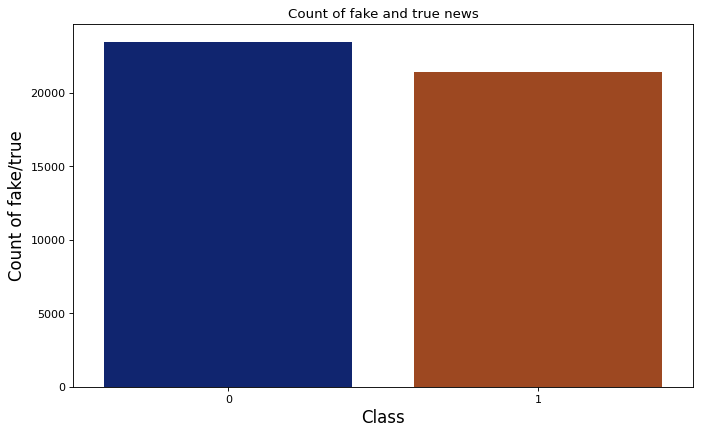

In [ ]:
figure(figsize=(10, 6), dpi=80)
ax=sns.countplot(x="label", data=df,palette="dark")

#Setting labels and font size
ax.set(xlabel='Class', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

**Wordcloud REAL News**

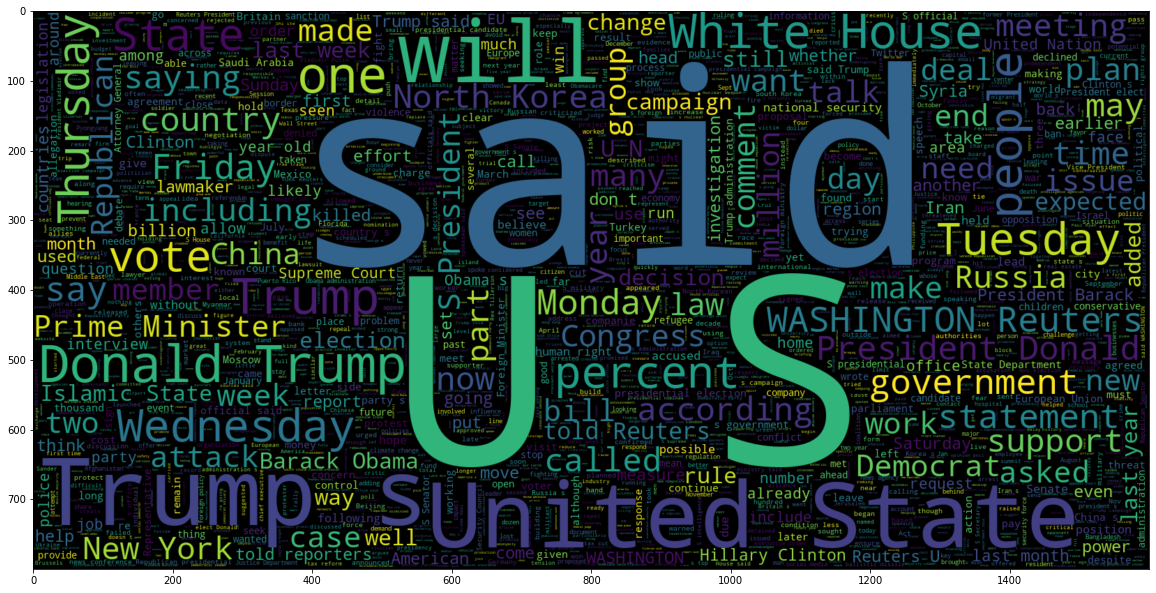

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Real
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**Wordcloud fake News**

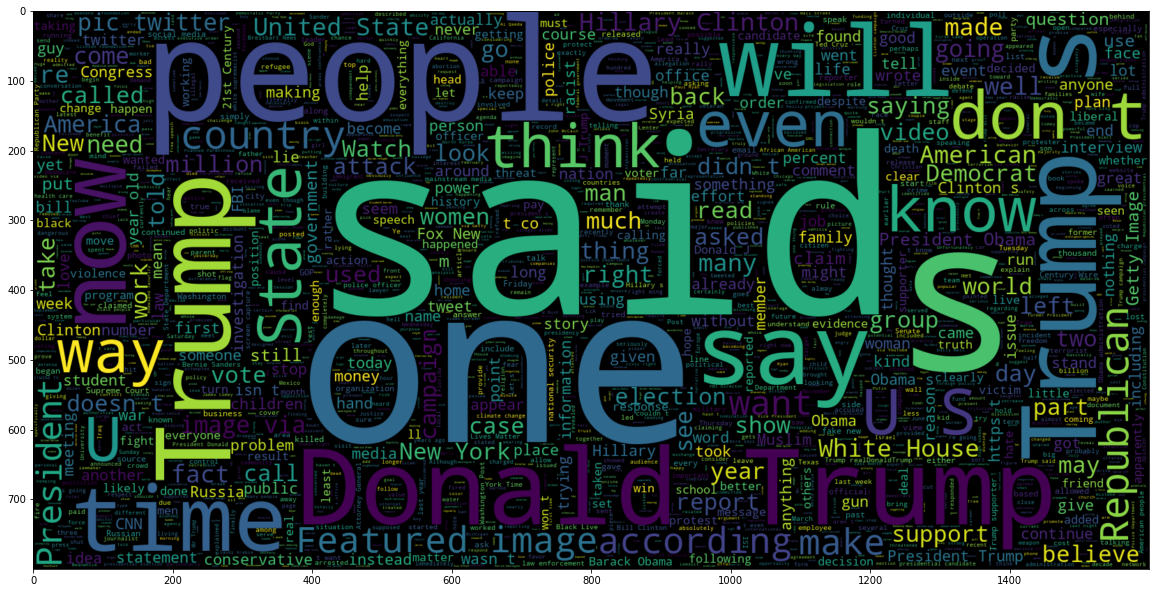

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of words in each text**

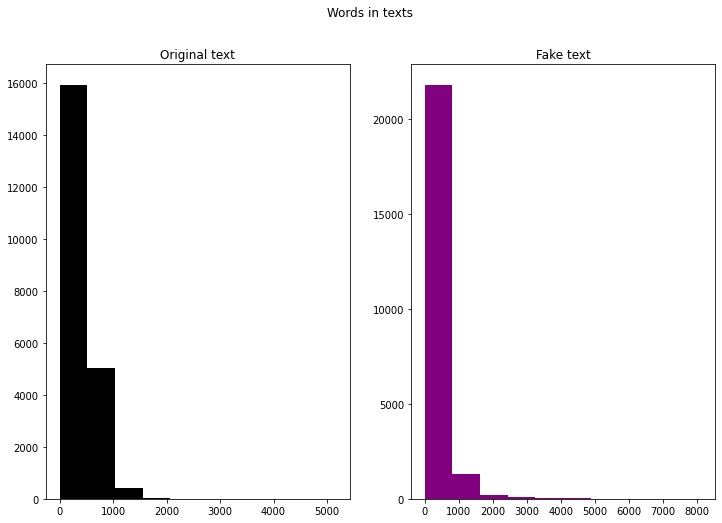

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='black')
ax1.set_title('Original text')
text_len=df[df['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='purple')
ax2.set_title('Fake text')
fig.suptitle('Words in texts')
plt.show()

**N-gram Analysis**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

**Bigram Analysis**

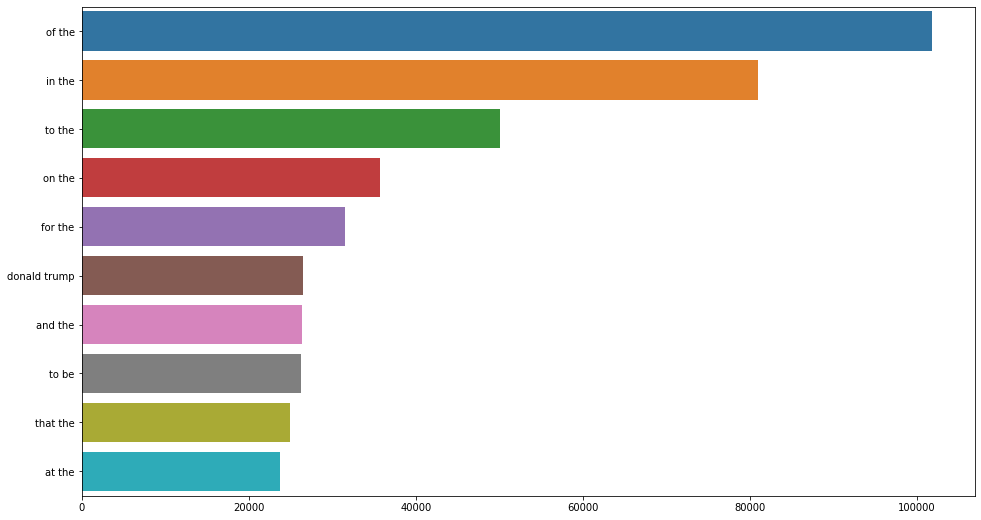

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

**Trigram Analysis**

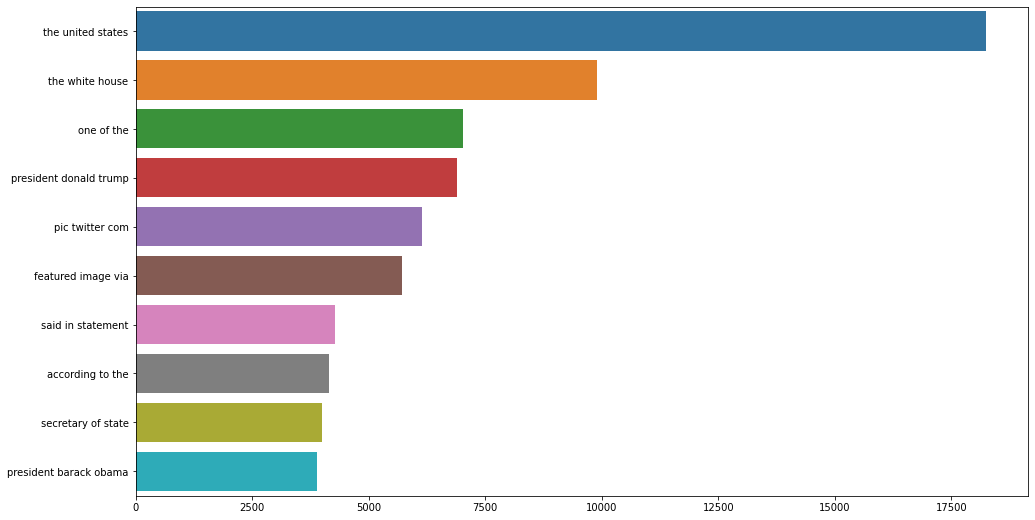

In [ ]:
plt.figure(figsize = (16,9))
most_common_tri = get_top_text_ngrams(df.text,10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

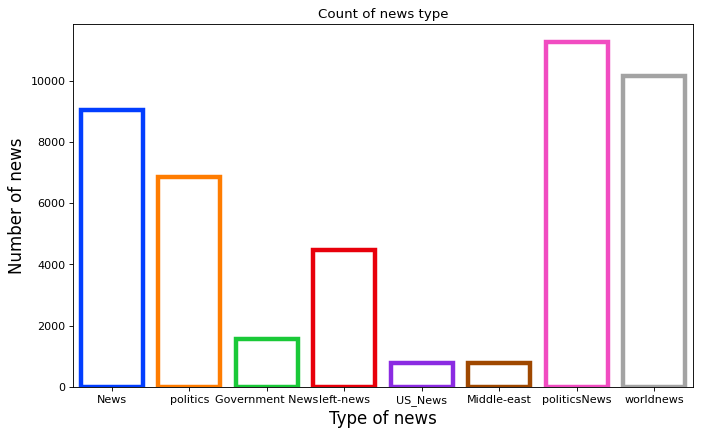

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)
ax = sns.countplot(x="subject", data=df,
                   facecolor=(0, 0, 0, 0),
                   linewidth=4,
                   edgecolor=sns.color_palette("bright", 8))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)




# Data Preparation

In [ ]:
df_fake["label"] = 0
df_true["label"] = 1
df = pd.concat([df_fake, df_true], axis =0 )
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [ ]:
df.drop([ 'date', 'subject'], axis=1, inplace=True) 

In [ ]:
#df.count()

In [ ]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [ ]:
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
df["text"] = df["text"].apply(wordopt)
df["title"] = df["title"].apply(wordopt)

In [ ]:
merge=df['title'].map(str) +' ' + df['text'].map(str) 

In [ ]:
df = df.assign(merged_text_title=merge)

In [ ]:
df

,title,text,label,merged_text_title
0,donald trump sends out embarrassing new year s...,donald trump wish americans happy new year lea...,0,donald trump sends out embarrassing new year s...
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,0,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes an internet joke ...,on friday revealed former milwaukee sheriff d...,0,sheriff david clarke becomes an internet joke ...
3,trump is so obsessed he even has obama s name ...,on christmas day donald trump announced would...,0,trump is so obsessed he even has obama s name ...
4,pope francis just called out donald trump duri...,pope francis used annual christmas day message...,0,pope francis just called out donald trump duri...
...,...,...,...,...
21412,fully committed nato backs new u s approach...,brussels reuters nato allies tuesday welco...,1,fully committed nato backs new u s approach...
21413,lexisnexis withdrew two products chinese market,london reuters lexisnexis provider legal ...,1,lexisnexis withdrew two products chinese marke...
21414,minsk cultural hub becomes authorities,minsk reuters in shadow disused soviet era...,1,minsk cultural hub becomes authorities minsk ...
21415,vatican upbeat possibility pope francis visiti...,moscow reuters vatican secretary state car...,1,vatican upbeat possibility pope francis visiti...


In [ ]:
data_labels = df.label.values
data_text= df.text.values
colmerge=df.merged_text_title.values
data_title=df.title.values

In [ ]:
max_value_merge= len(colmerge.max())
max_value_merge

2944

In [ ]:
max_value_title = len(data_title.max())
max_value_title

74

In [ ]:
max_value_text = len(data_text.max())
max_value_text

1082

**MAX values for data text**

In [ ]:
max_text=max(data_text)
max_text

'zurich  reuters    three people died separate avalanche accidents swiss alps  police said monday  a man skiing close   metre high hofathorn  southern canton wallis  died carried away avalanche monday morning  the  year old wallis region quickly found recovered friends confirmed dead scene emergency services  police graubunden  east switzerland  said tourist went missing saturday also found dead  the  year old frenchman tried climb glattwang mountain alone saturday afternoon skiing girlfriend  when return  search launched man body found ravine sunday morning  police said triggered avalanche descent carried kilometre rocky terrain  separately  one three walkers buried snow drift wallis saturday died  swiss broadcaster srf reported  quoting police  the group hiking height   meters st luc region accident happened  one managed get free make emergency call allowed others rescued  all three flown hospital  one   year old woman swiss canton vaud  died injuries sunday evening  srf said   this 

In [ ]:
#lenght before tokenization
len(max_text)

1082

**import BERT BASE model**

In [ ]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
tokens_text=tokenizer.tokenize(max_text)
tokens_text

['zurich',
 'reuters',
 'three',
 'people',
 'died',
 'separate',
 'avalanche',
 'accidents',
 'swiss',
 'alps',
 'police',
 'said',
 'monday',
 'a',
 'man',
 'skiing',
 'close',
 'metre',
 'high',
 'ho',
 '##fat',
 '##horn',
 'southern',
 'canton',
 'wallis',
 'died',
 'carried',
 'away',
 'avalanche',
 'monday',
 'morning',
 'the',
 'year',
 'old',
 'wallis',
 'region',
 'quickly',
 'found',
 'recovered',
 'friends',
 'confirmed',
 'dead',
 'scene',
 'emergency',
 'services',
 'police',
 'gr',
 '##au',
 '##bund',
 '##en',
 'east',
 'switzerland',
 'said',
 'tourist',
 'went',
 'missing',
 'saturday',
 'also',
 'found',
 'dead',
 'the',
 'year',
 'old',
 'frenchman',
 'tried',
 'climb',
 'g',
 '##lat',
 '##t',
 '##wang',
 'mountain',
 'alone',
 'saturday',
 'afternoon',
 'skiing',
 'girlfriend',
 'when',
 'return',
 'search',
 'launched',
 'man',
 'body',
 'found',
 'ravine',
 'sunday',
 'morning',
 'police',
 'said',
 'triggered',
 'avalanche',
 'descent',
 'carried',
 'kilometre',
 

In [ ]:
#lenght after tokenization
len(tokens_text)
max_lenght=len(tokens_text)
max_lenght

167

**MAX values for data merged**

In [ ]:
max_merge=max(colmerge)
max_merge

'zuma spokesman dismisses reports south african deputy president may sacked johannesburg  reuters    jacob zuma spokesman said friday basis reports south african president would axe deputy cyril ramaphosa  speculation weighed currency bonds  the ruling african national congress  anc  party  zuma leader ramaphosa deputy  riven bitter infighting ahead party conference december new leader chosen  it rumors gossip  comment all  zuma spokesman bongani ngqulunga told reuters  ramaphosa  trade unionist turned business tycoon  viewed likely rival candidate nkosazana dlamini zuma  former chairwoman african union  zuma pick leadership president ex wife  he recently stepped criticism zuma scandal plagued government  asked parliament thursday whether might sacked  ramaphosa said would accept president decision lost job  on friday  spokesman deputy president said  we aware speculation  speculation  trade union federation cosatu south african communist party  sacp   partners anc ruling alliance  end

In [ ]:
#lenght before tokenization
len(max_merge)

2944

In [ ]:
tokens_merg=tokenizer.tokenize(max_merge)
tokens_merg

['zu',
 '##ma',
 'spokesman',
 'dismiss',
 '##es',
 'reports',
 'south',
 'african',
 'deputy',
 'president',
 'may',
 'sacked',
 'johannesburg',
 'reuters',
 'jacob',
 'zu',
 '##ma',
 'spokesman',
 'said',
 'friday',
 'basis',
 'reports',
 'south',
 'african',
 'president',
 'would',
 'axe',
 'deputy',
 'cyril',
 'rama',
 '##ph',
 '##osa',
 'speculation',
 'weighed',
 'currency',
 'bonds',
 'the',
 'ruling',
 'african',
 'national',
 'congress',
 'an',
 '##c',
 'party',
 'zu',
 '##ma',
 'leader',
 'rama',
 '##ph',
 '##osa',
 'deputy',
 'ri',
 '##ven',
 'bitter',
 'in',
 '##fighting',
 'ahead',
 'party',
 'conference',
 'december',
 'new',
 'leader',
 'chosen',
 'it',
 'rumors',
 'gossip',
 'comment',
 'all',
 'zu',
 '##ma',
 'spokesman',
 'bon',
 '##gan',
 '##i',
 'ng',
 '##qu',
 '##lun',
 '##ga',
 'told',
 'reuters',
 'rama',
 '##ph',
 '##osa',
 'trade',
 'unionist',
 'turned',
 'business',
 'ty',
 '##co',
 '##on',
 'viewed',
 'likely',
 'rival',
 'candidate',
 'nk',
 '##osa',
 '##za

In [ ]:
#lengbht after tokenization
len(tokens_merg)

475

In [ ]:
#len(max(tokens))
#to be executed
#all_words = [word for tokens in df_allnews_unpickled["tokens"] for word in tokens]
#all_sentence_lengths =[len(token) for token in tokens]
#ave_sentence_lengths = sum(all_sentence_lengths)/len(all_sentence_lengths)
# = sorted(list(set(all_words)))
#all_sentence_lengths

# BERT Embedding

In [ ]:
def get_masks(text, max_length):
    """Mask for padding"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),()->(n)')

In [ ]:
def get_segments(text, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]
    
    segments = []
    current_segment_id = 0
    with_tags = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),()->(n)')

In [ ]:
def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

In [ ]:
def prepare(text_array, tokenizer, max_length = 128):
    
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze()
    masks = vec_get_masks(text_array,
                      max_length).squeeze()
    segments = vec_get_segments(text_array,
                      max_length).squeeze()

    return ids, segments, masks

**Sentence Toknization**


In [ ]:
sentence='Hello, I love strawberries'

In [ ]:
tokenizer.tokenize(sentence)

['hello', ',', 'i', 'love', 'straw', '##berries']

In [ ]:
max_length =12 # that must be set according to your dataset default value 128
ids, segment, mask = prepare(sentence,tokenizer,max_length)

In [ ]:
ids

array([  101,  7592,  1010,  1045,  2293, 13137, 20968,   102,     0,
           0,     0,     0])

In [ ]:
print('ids  {} \nsegments {}\nmasks {}'.format(ids,segment,mask))



ids  [  101  7592  1010  1045  2293 13137 20968   102     0     0     0     0] 
segments [0 0 0 0 0 0 0 0 0 0 0 0]
masks [1 1 1 1 1 1 1 1 0 0 0 0]


In [ ]:
segment.shape

(12,)

**lets toknize the dataset**

In [ ]:
max_len = 512

In [ ]:
  # that must be set according to your dataset
ids_input, segments_ids, masks_attention= prepare(colmerge,tokenizer,max_len)

In [ ]:
print('ids  {} \nsegments_ids {} \nmasks {}'.format(ids_input.shape,segments_ids.shape,masks_attention.shape))

ids  (44898, 512) 
segments_ids (44898, 512) 
masks (44898, 512)


In [ ]:
with open('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/embeddings_Bert/input.pickle', 'wb') as handle:
    pickle.dump((ids_input), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/embeddings_Bert/segment.pickle', 'wb') as handle:
    pickle.dump((segments_ids), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/embeddings_Bert/mask.pickle', 'wb') as handle:
    pickle.dump((masks_attention), handle, protocol=pickle.HIGHEST_PROTOCOL)


#Load saved files for embedding

In [ ]:
import pickle
print('Loading the saved pickle files..')

input_ids=pickle.load(open('/content/drive/MyDrive/BERT/bert_lstm/input.pickle', 'rb'))
attention_masks=pickle.load(open('/content/drive/MyDrive/BERT/bert_lstm/mask.pickle', 'rb'))
tokens_ids=pickle.load(open('/content/drive/MyDrive/BERT/bert_lstm/segment.pickle', 'rb'))


Loading the saved pickle files..


In [ ]:
print('shape for the loaded files \nInput shape {}  \nAttention mask shape {}  \nTokens_ids shape {}'.format(input_ids.shape,attention_masks.shape,tokens_ids.shape))


shape for the loaded files 
Input shape (44898, 512)  
Attention mask shape (44898, 512)  
Tokens_ids shape (44898, 512)


**Split of data**

In [ ]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask,train_segment,val_segment=train_test_split(input_ids,data_labels,attention_masks,tokens_ids,test_size=0.2)

print('Train inp shape {} \nVal input shape {}\nTrain label shape {} \nVal label shape {}\nTrain attention mask shape {} \nVal attention mask shape {} \ntrain_segment {} \nval_segment {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape,train_segment.shape,val_segment.shape))



Train inp shape (35918, 512) 
Val input shape (8980, 512)
Train label shape (35918,) 
Val label shape (8980,)
Train attention mask shape (35918, 512) 
Val attention mask shape (8980, 512) 
train_segment (35918, 512) 
val_segment (8980, 512)


In [ ]:
max_len=512

In [ ]:
input_word_ids = layers.Input(shape=(max_len,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_len,), dtype=tf.int32,
                                   name="input_masks")
segment_ids = layers.Input(shape=(max_len,), dtype=tf.int32,
                                    name="segment_ids")
den_out, seq_out = bert_layer([input_word_ids, input_mask, segment_ids])

In [ ]:
print('Input shape {} Attention mask shape {} Input lsegment shape {}'.format(input_word_ids.shape,input_mask.shape,segment_ids.shape))


Input shape (None, 512) Attention mask shape (None, 512) Input lsegment shape (None, 512)




# BERT CNN

**Training**

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/Cnn_bert.hdf5')

In [ ]:
convs = []
filter_sizes = [3,4,5]

for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(seq_out)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


l_merge = concatenate(convs, axis=1)

x = Dropout(0.5)(l_merge)  
preds = Dense(1, activation='sigmoid')(x)
cnn_Bert= tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[preds])

In [ ]:
cnn_Bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',        

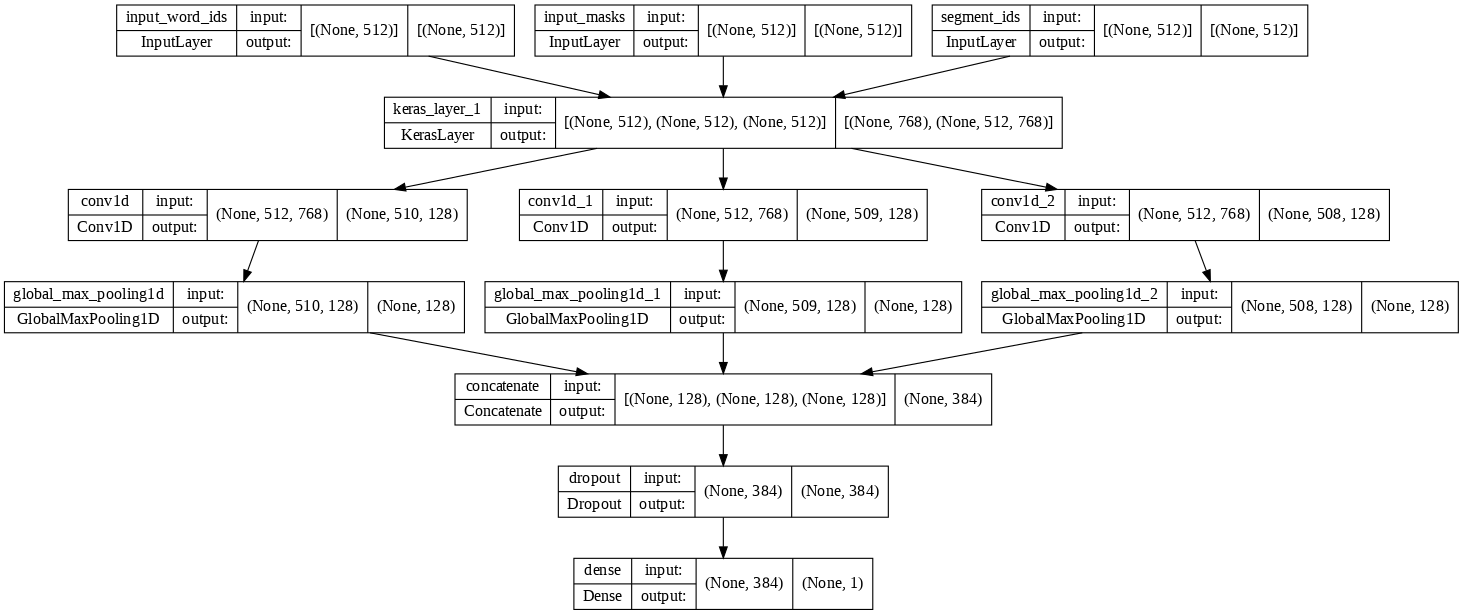

In [ ]:
tf.keras.utils.plot_model(
    cnn_Bert,
    to_file="Bert_cnn.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=80,
   
)

In [ ]:
cnn_Bert.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])


In [ ]:
FindBatchSize(cnn_Bert)

Batch Size:  1


1

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
csv_logger_cnn = callbacks.CSVLogger('cnn_Bert.log')
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/Cnn_bert.hdf5')



In [ ]:
from time import time
start =time()

history = cnn_Bert.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 15,
          batch_size=1,
          validation_split = 0.2,
          callbacks = [es,csv_logger_cnn]
          )


Epoch 1/15
28734/28734 [==============================] - 1779s 61ms/step - loss: 0.1677 - accuracy: 0.9763 - val_loss: 0.0188 - val_accuracy: 0.9974
Epoch 2/15
28734/28734 [==============================] - 1742s 61ms/step - loss: 0.0820 - accuracy: 0.9924 - val_loss: 0.0276 - val_accuracy: 0.9981
Epoch 3/15
28734/28734 [==============================] - 1790s 62ms/step - loss: 0.0665 - accuracy: 0.9948 - val_loss: 0.0360 - val_accuracy: 0.9976
Epoch 4/15
28734/28734 [==============================] - 1733s 60ms/step - loss: 0.0530 - accuracy: 0.9957 - val_loss: 0.0244 - val_accuracy: 0.9990
Epoch 5/15
28734/28734 [==============================] - 1800s 63ms/step - loss: 0.0464 - accuracy: 0.9967 - val_loss: 0.0299 - val_accuracy: 0.9987
Epoch 6/15
28734/28734 [==============================] - 1829s 64ms/step - loss: 0.0470 - accuracy: 0.9963 - val_loss: 0.0234 - val_accuracy: 0.9990
Epoch 7/15
28734/28734 [==============================] - 1822s 63ms/step - loss: 0.0341 - accuracy:

In [ ]:
cnn_Bert.save(model_path)

In [ ]:
print(time()-start)

19761.091641426086


In [ ]:
# Load the log file
df_model_cnn = pd.read_csv('cnn_Bert.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_cnn['epoch'], y=df_model_cnn['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_cnn['epoch'], y=df_model_cnn['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_cnn['epoch'], y=df_model_cnn['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_cnn['epoch'], y=df_model_cnn['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
cnn_Bert.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 435s 48ms/step - loss: 0.0402 - accuracy: 0.9988


[0.04017004743218422, 0.998775064945221]

In [ ]:
y_pred_cnn =np.round(cnn_Bert.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_cnn))
print(recall_score(val_label,y_pred_cnn))
print(f1_score(val_label,y_pred_cnn))

0.9985818955329709
0.9988179669030733
0.9986999172674624


In [ ]:
print(classification_report(val_label, y_pred_cnn, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4750
           1       1.00      1.00      1.00      4230

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
cnn = confusion_matrix(val_label,y_pred_cnn,labels=labels)

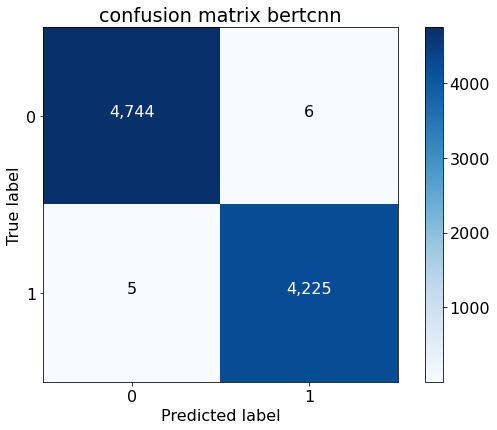

In [ ]:
plot_confusion_matrix(cnn,title='confusion matrix bertcnn',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'bert_cnn_vreview_cm.svg')

#  BERT LSTM

In [ ]:
X = layers.LSTM(128)(seq_out)
X = layers.Dropout(0.5)(X)
X = layers.Dense(256, activation="relu")(X)
X = layers.Dropout(0.5)(X)
output = layers.Dense(1, activation="sigmoid")(X)

Bert_Lstm = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[output])


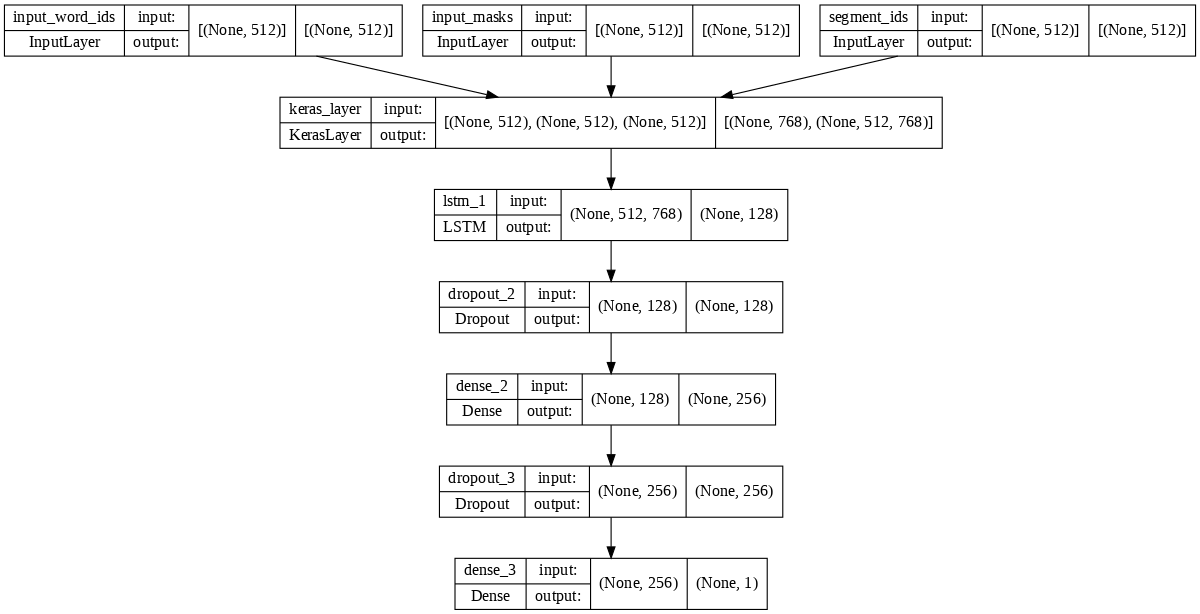

In [ ]:
tf.keras.utils.plot_model(
    Bert_Lstm,
    to_file="Bert_Lstm.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=80,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
Bert_Lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',      

In [ ]:
Bert_Lstm.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
#Bert_Lstm.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
FindBatchSize(Bert_Lstm)

Batch Size:  1


1

**Early Stoping**

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_lstm_bert = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/BERT_LSTM.log')


In [ ]:
from time import time
start =time()

history = Bert_Lstm.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 5,
          batch_size = 32,
          validation_split = 0.2,
          callbacks = [es,csv_logger_lstm_bert]
          )

Epoch 1/5
898/898 [==============================] - 1687s 2s/step - loss: 0.2886 - accuracy: 0.8806 - val_loss: 0.2039 - val_accuracy: 0.9208
Epoch 2/5
898/898 [==============================] - 1682s 2s/step - loss: 0.1892 - accuracy: 0.9326 - val_loss: 0.1782 - val_accuracy: 0.9303
Epoch 3/5
898/898 [==============================] - 1681s 2s/step - loss: 0.1053 - accuracy: 0.9638 - val_loss: 0.0549 - val_accuracy: 0.9833
Epoch 4/5
898/898 [==============================] - 1681s 2s/step - loss: 0.0490 - accuracy: 0.9844 - val_loss: 0.0226 - val_accuracy: 0.9925
Epoch 5/5
898/898 [==============================] - 1681s 2s/step - loss: 0.0284 - accuracy: 0.9904 - val_loss: 0.0314 - val_accuracy: 0.9898


In [ ]:
print(time()-start)

8426.323729515076


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/Lstm_bert.hdf5')
Bert_Lstm.save(model_path)

In [ ]:
from tensorflow import keras
my_reloaded_model_bert_lstm= tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/VariantRcnn.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

**Result Bert_Lstm**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from tensorflow import keras
my_reloaded_model_bert_lstm = tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/Lstm_bert.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/modelspart2/Lstm_bert_part2.hdf5')

In [ ]:
my_reloaded_model_bert_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_lstm_bert= callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/bert_lstm_v2.log')
checkpointer=tf.keras.callbacks.ModelCheckpoint(filepath=model_path,verbose=1,save_best_only=True)

In [ ]:
from time import time
start =time()

history = my_reloaded_model_bert_lstm.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs =10,
          batch_size = 32,
          validation_split = 0.2,
          callbacks = [es,csv_logger_lstm_bert,checkpointer]
          )

Epoch 1/10
898/898 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9910
Epoch 1: val_loss improved from inf to 0.01324, saving model to /content/drive/MyDrive/BERT/models/modelspart2/Lstm_bert_part2.hdf5
898/898 [==============================] - 1596s 2s/step - loss: 0.0293 - accuracy: 0.9910 - val_loss: 0.0132 - val_accuracy: 0.9953
Epoch 2/10
898/898 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9940
Epoch 2: val_loss did not improve from 0.01324
898/898 [==============================] - 1589s 2s/step - loss: 0.0188 - accuracy: 0.9940 - val_loss: 0.0194 - val_accuracy: 0.9937
Epoch 3/10
898/898 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9951
Epoch 3: val_loss improved from 0.01324 to 0.01004, saving model to /content/drive/MyDrive/BERT/models/modelspart2/Lstm_bert_part2.hdf5
898/898 [==============================] - 1597s 2s/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0100 - val_accuracy: 0.996

In [ ]:
my_reloaded_model_bert_lstm.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 484s 54ms/step - loss: 0.0225 - accuracy: 0.9905


[0.022476546466350555, 0.9905345439910889]

In [ ]:
print(time()-start)

11654.871961832047


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/modelpart2/lstm_bert_part2.hdf5')
my_reloaded_model_bert_lstm.save(model_path)

In [ ]:
y_pred_lstm_bert =np.round(my_reloaded_model_bert_lstm.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_lstm_bert))
print(recall_score(val_label,y_pred_lstm_bert))
print(f1_score(val_label,y_pred_lstm_bert))

0.981549815498155
0.9988265665336775
0.9901128300569966


In [ ]:
print(classification_report(val_label, y_pred_lstm_bert, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4719
           1       0.98      1.00      0.99      4261

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
Cnn_lstm = confusion_matrix(val_label,y_pred_lstm_bert,labels=labels)

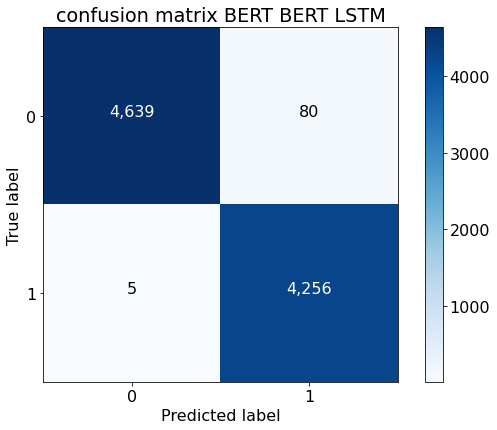

In [ ]:
plot_confusion_matrix(Cnn_lstm,title='confusion matrix BERT BERT LSTM',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'Cnn_lstm_vreview_cm.svg')

In [ ]:
# Load the log file
df_model = pd.read_csv('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/log_file/BERT_LSTM.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model['epoch'], y=df_model['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model['epoch'], y=df_model['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model['epoch'], y=df_model['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model['epoch'], y=df_model['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

# BERT BILSTM

In [ ]:
l_bilstm =Bidirectional(LSTM(128))(seq_out)

In [ ]:
x3 = Dropout(0.3)(l_bilstm) 

In [ ]:
output = Dense(1, activation='sigmoid')(x3)


In [ ]:
Bilstm_bert =tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[output])

In [ ]:
Bilstm_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',        

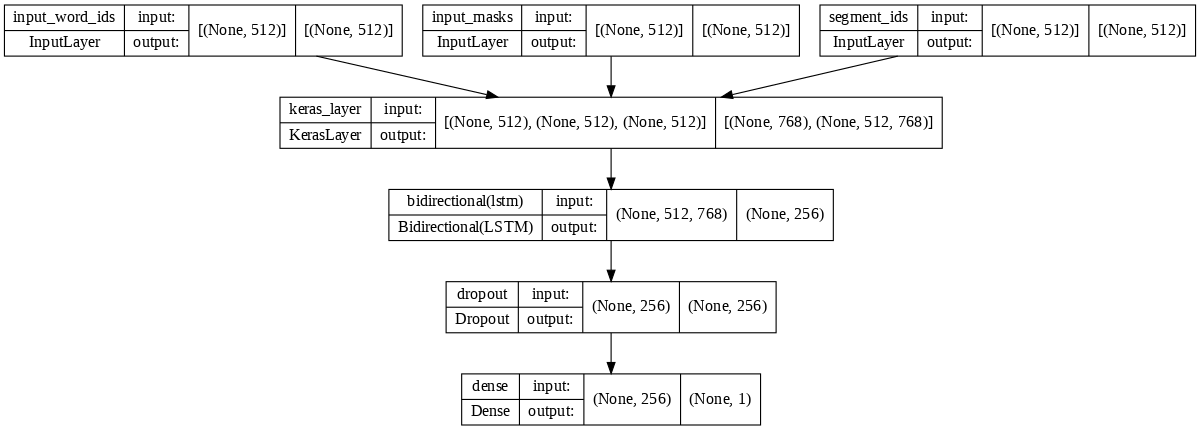

In [ ]:
tf.keras.utils.plot_model(
    Bilstm_bert,
    to_file="Bert_Lstm.png",
     show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=80,
    
    
)

In [ ]:
Bilstm_bert.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_bilstm = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/BERT_BiLSTM.log')




In [ ]:
from time import time
start =time()


history = Bilstm_bert.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 5,
          batch_size=128,
          validation_split = 0.2,
          callbacks = [es,csv_logger_bilstm]
          )

Epoch 1/5
225/225 [==============================] - 1723s 8s/step - loss: 0.0555 - accuracy: 0.9774 - val_loss: 0.0114 - val_accuracy: 0.9961
Epoch 2/5
225/225 [==============================] - 1702s 8s/step - loss: 0.0131 - accuracy: 0.9953 - val_loss: 0.0076 - val_accuracy: 0.9979
Epoch 3/5
225/225 [==============================] - 1700s 8s/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 0.0083 - val_accuracy: 0.9968
Epoch 4/5
225/225 [==============================] - 1698s 8s/step - loss: 0.0085 - accuracy: 0.9969 - val_loss: 0.0060 - val_accuracy: 0.9976
Epoch 5/5
225/225 [==============================] - 1697s 8s/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0053 - val_accuracy: 0.9982


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/BiLstm_bert.hdf5')
Bilstm_bert.save(model_path)

In [ ]:
print(time()-start)

8556.440795898438


In [ ]:
from tensorflow import keras
my_reloaded_model_bert_Bilstm= tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/BiLstm_bert.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/modelspart2/bert_bilstm_part2.hdf5')
my_reloaded_model_bert_Bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_VRcnn = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/bertbilstm_v2.log')
checkpointer=tf.keras.callbacks.ModelCheckpoint(filepath=model_path,verbose=1,save_best_only=True)

In [ ]:
from time import time
start =time()

history = my_reloaded_model_bert_Bilstm.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 10,
          batch_size = 128,
          validation_split = 0.2,
          callbacks = [es,csv_logger_VRcnn,checkpointer]
          )

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9977
Epoch 1: val_loss improved from inf to 0.00578, saving model to /content/drive/MyDrive/BERT/models/modelspart2/bert_bilstm_part2.hdf5
225/225 [==============================] - 1767s 8s/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0058 - val_accuracy: 0.9976
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9985
Epoch 2: val_loss improved from 0.00578 to 0.00170, saving model to /content/drive/MyDrive/BERT/models/modelspart2/bert_bilstm_part2.hdf5
225/225 [==============================] - 1752s 8s/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0017 - val_accuracy: 0.9994
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9992
Epoch 3: val_loss improved from 0.00170 to 0.00064, saving model to /content/drive/MyDrive/BERT/models/modelspart2/bert_bilstm_part2.hdf5
225/225 [===========================

In [ ]:
my_reloaded_model_bert_Bilstm.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 601s 66ms/step - loss: 0.0062 - accuracy: 0.9979


[0.006154940463602543, 0.997884213924408]

In [ ]:
print(time()-start)

11103.00506067276


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/modelpart2/Bilstm_bert_part2.hdf5')
my_reloaded_model_bert_Bilstm.save(model_path)

In [ ]:
y_pred_bert_bilstm =np.round(my_reloaded_model_bert_Bilstm.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_bert_bilstm))
print(recall_score(val_label,y_pred_bert_bilstm))
print(f1_score(val_label,y_pred_bert_bilstm))

0.9997651479567872
0.9957894736842106
0.9977733505215048


In [ ]:
print(classification_report(val_label, y_pred_bert_bilstm, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4705
           1       1.00      1.00      1.00      4275

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
Cnn_lstm = confusion_matrix(val_label,y_pred_bert_bilstm,labels=labels)

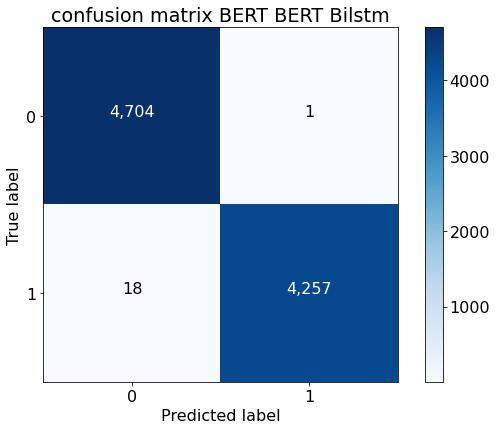

In [ ]:
plot_confusion_matrix(Cnn_lstm,title='confusion matrix BERT BERT Bilstm',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/BPFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'Cnn_lstm_vreview_cm.svg')

In [ ]:
df_model_bilstm = pd.read_csv('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/log_file/BERT_BiLSTM.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_bilstm['epoch'], y=df_model_bilstm['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_bilstm['epoch'], y=df_model_bilstm['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_bilstm['epoch'], y=df_model_bilstm['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_bilstm['epoch'], y=df_model_bilstm['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')



#BERT GRU

In [ ]:
gru=layers.GRU(128)(seq_out)
dropout= Dropout(0.1)(gru)
output = Dense(1, activation='sigmoid')(dropout)  
GRU_Bert= tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[output])

In [ ]:
GRU_Bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',        

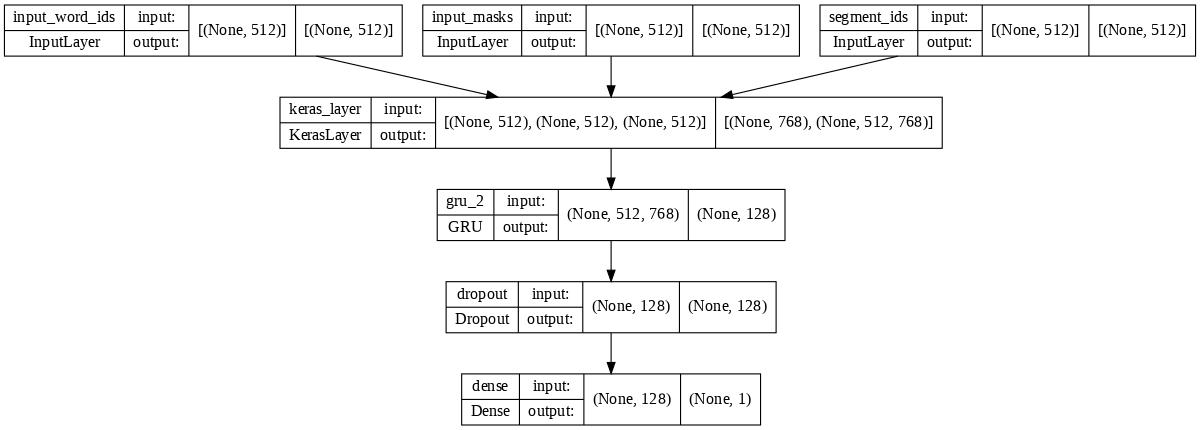

In [ ]:
tf.keras.utils.plot_model(
    GRU_Bert,
    to_file="Bert_ft.png",
    show_shapes=True,
    
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=80,
   
)

In [ ]:
GRU_Bert.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
FindBatchSize(GRU_Bert)

Batch Size:  1


1

In [ ]:
csv_logger_GRU_Bert = callbacks.CSVLogger('GRU_Bert.log')
Es=callbacks.EarlyStopping( monitor='val_accuracy', 
    patience=2,min_delta=0.0001,mode='max', restore_best_weights=True)

In [ ]:
from time import time
start =time()

history = GRU_Bert.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 20,
          batch_size = 512,
          validation_split = 0.3,
          callbacks = [csv_logger_GRU_Bert]
          )

Epoch 1/15
28734/28734 [==============================] - 2092s 72ms/step - loss: 0.0485 - accuracy: 0.9805 - val_loss: 0.0130 - val_accuracy: 0.9964
Epoch 2/15
28734/28734 [==============================] - 2102s 73ms/step - loss: 0.0091 - accuracy: 0.9973 - val_loss: 0.0143 - val_accuracy: 0.9968
Epoch 3/15
28734/28734 [==============================] - 2106s 73ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0120 - val_accuracy: 0.9971
Epoch 4/15
28734/28734 [==============================] - 2106s 73ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0127 - val_accuracy: 0.9976
Epoch 5/15
28734/28734 [==============================] - 2109s 73ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0130 - val_accuracy: 0.9975
Epoch 6/15
28734/28734 [==============================] - 2129s 74ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0174 - val_accuracy: 0.9964
Epoch 7/15
28734/28734 [==============================] - 2126s 74ms/step - loss: 0.0037 - accuracy:

In [ ]:
print(time()-start)

27400.225431203842


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/GRU_bert.hdf5')
GRU_Bert.save(model_path)

In [ ]:
#df_model_gru = pd.read_csv('GRU_Bert.log')
df_model_gru= pd.read_csv('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/GRU_BERT_LSTM.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_gru['epoch'], y=df_model_gru['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_gru['epoch'], y=df_model_gru['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_gru['epoch'], y=df_model_gru['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_gru['epoch'], y=df_model_gru['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
GRU_Bert.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 483s 54ms/step - loss: 0.0071 - accuracy: 0.9987


[0.007106349337846041, 0.9986637234687805]

In [ ]:
from tensorflow import keras
my_reloaded_model_gru= tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/GRU_bert.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
y_pred_gru =np.round(my_reloaded_model_gru.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_gru))
print(recall_score(val_label,y_pred_gru))
print(f1_score(val_label,y_pred_gru))

1.0
0.9993005362555374
0.9996501457725947


In [ ]:
print(classification_report(val_label, y_pred_gru, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4691
           1       1.00      1.00      1.00      4289

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
gru = confusion_matrix(val_label,y_pred_gru,labels=labels)

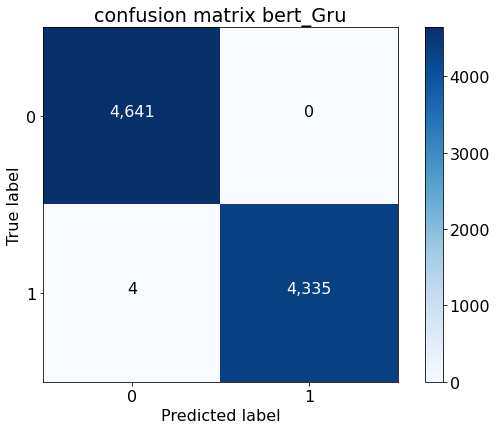

In [ ]:
plot_confusion_matrix(gru,title='confusion matrix bert_Gru',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'bert_gru_vreview_cm.svg')

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
cohen_kappa_score(val_label,y_pred_gru)

0.9993304868171016

In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(val_label,y_pred_gru,sample_weight=None)

0.9993307107910738





#BERT CNN LSTM

In [ ]:
conv_output =layers.Conv1D(filters=300, kernel_size=3, activation='relu')(seq_out)
pool=layers.MaxPooling1D()(conv_output)
lstm_output = LSTM(300,go_backwards=True)(pool)
preds = Dense(1, activation="sigmoid")(lstm_output)
Cnn_lstm = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[preds])
Cnn_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',        

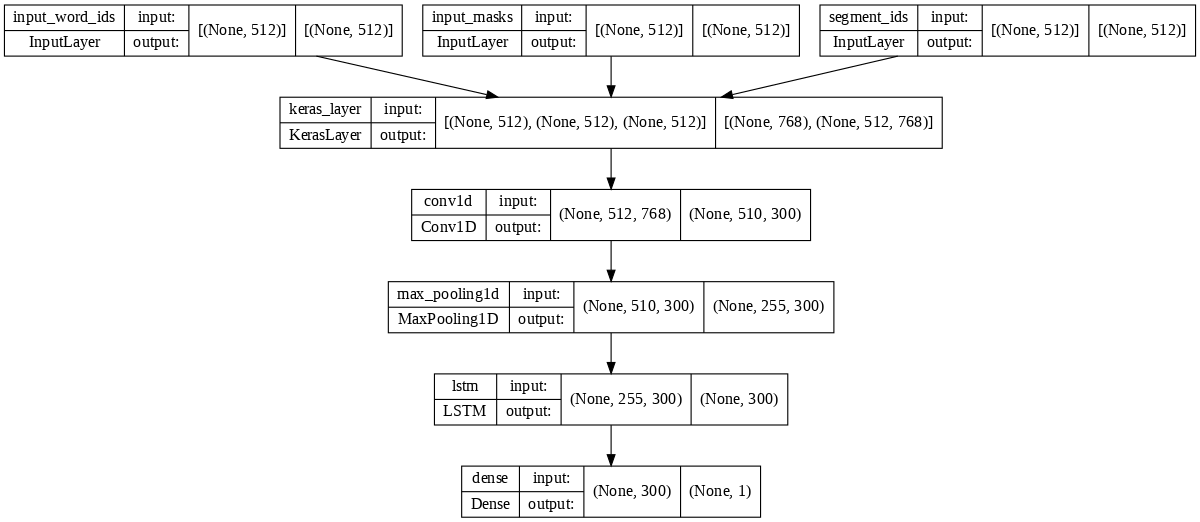

In [ ]:
tf.keras.utils.plot_model(
    Cnn_lstm,
    to_file="Bert_Lstm.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=80,
    layer_range=None,
    show_layer_activations=False,
)


In [ ]:
Cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
#csv_logger_cnn_lstm = callbacks.CSVLogger('CNN_LSTM.log')
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_cnn_lstm = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/CNN_LSTM.log')

In [ ]:
from time import time
start =time()

history = Cnn_lstm.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 10,
          batch_size = 1,
          validation_split = 0.2,
          callbacks = [es,csv_logger_cnn_lstm]
          )

Epoch 1/10
28734/28734 [==============================] - 2037s 70ms/step - loss: 0.0518 - accuracy: 0.9791 - val_loss: 0.0165 - val_accuracy: 0.9951
Epoch 2/10
28734/28734 [==============================] - 2033s 71ms/step - loss: 0.0188 - accuracy: 0.9938 - val_loss: 0.0128 - val_accuracy: 0.9954
Epoch 3/10
28734/28734 [==============================] - 2057s 72ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0109 - val_accuracy: 0.9968
Epoch 4/10
28734/28734 [==============================] - 2058s 72ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 0.0097 - val_accuracy: 0.9968
Epoch 5/10
28734/28734 [==============================] - 2052s 71ms/step - loss: 0.0087 - accuracy: 0.9969 - val_loss: 0.0126 - val_accuracy: 0.9962
Epoch 6/10
28734/28734 [==============================] - 2046s 71ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0083 - val_accuracy: 0.9971
Epoch 7/10
28734/28734 [==============================] - 2046s 71ms/step - loss: 0.0068 - accuracy:

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/Cnn_Lstm.hdf5')
Cnn_lstm.save(model_path)

In [ ]:
from tensorflow import keras
my_reloaded_model_bertClstm= tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/modelspart2/clstm_bert_part2.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/modelspart2/CNN_Lstm_bert_part3.hdf5')

In [ ]:
my_reloaded_model_bertClstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_cnn_lstm= callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/bert_Cnn_lstm_v2.log')
checkpointer=tf.keras.callbacks.ModelCheckpoint(filepath=model_path,verbose=1,save_best_only=True)

In [ ]:
from time import time
start =time()

history = my_reloaded_model_bertClstm.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 10,
          batch_size = 1,
          validation_split = 0.2,
          callbacks = [es,csv_logger_cnn_lstm,checkpointer]
          )

Epoch 1/10
28734/28734 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9988
Epoch 1: val_loss improved from inf to 0.00813, saving model to /content/drive/MyDrive/BERT/models/modelspart2/CNN_Lstm_bert_part3.hdf5
28734/28734 [==============================] - 2134s 73ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0081 - val_accuracy: 0.9978
Epoch 2/10
28734/28734 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9989
Epoch 2: val_loss improved from 0.00813 to 0.00602, saving model to /content/drive/MyDrive/BERT/models/modelspart2/CNN_Lstm_bert_part3.hdf5
28734/28734 [==============================] - 2113s 74ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 3/10
28734/28734 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9989
Epoch 3: val_loss did not improve from 0.00602
28734/28734 [==============================] - 2113s 74ms/step - loss: 0.0047 - accuracy: 0.9989 - 

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection//modelpart2/lstmCNN_bert_part2.hdf5')
my_reloaded_model_bertClstm.save(model_path)

In [ ]:
print(time()-start)

8957.026124238968


In [ ]:
my_reloaded_model_bertClstm.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 475s 53ms/step - loss: 0.0044 - accuracy: 0.9988


[0.004362295847386122, 0.998775064945221]

In [ ]:
y_pred_Cnn_lstm =np.round(my_reloaded_model_bertClstm.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_Cnn_lstm))
print(recall_score(val_label,y_pred_Cnn_lstm))
print(f1_score(val_label,y_pred_Cnn_lstm))


0.9995290793501295
0.9978843441466855
0.9987060345841666


In [ ]:
print(classification_report(val_label, y_pred_Cnn_lstm, labels=[0,1]))

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
Cnn_lstm = confusion_matrix(val_label,y_pred_Cnn_lstm,labels=labels)

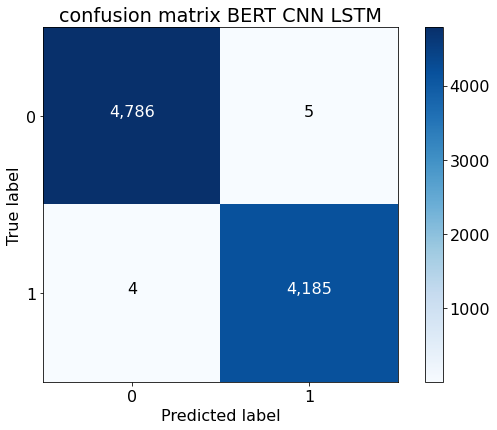

In [ ]:
plot_confusion_matrix(Cnn_lstm,title='confusion matrix BERT CNN LSTM',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'Cnn_lstm_vreview_cm.svg')

In [ ]:
df_model_CLSTM = pd.read_csv('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/log_file/CNN_LSTM.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_CLSTM['epoch'], y=df_model_CLSTM['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_CLSTM['epoch'], y=df_model_CLSTM['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_CLSTM['epoch'], y=df_model_CLSTM['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_CLSTM['epoch'], y=df_model_CLSTM['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')




# BERT RCNN Variant

In [ ]:
bilstm=layers.Bidirectional(LSTM(128, return_sequences=True))(seq_out)

In [ ]:
merge=concatenate([bilstm,seq_out])

In [ ]:

convs = []
filter_sizes = [1,2,3,4,5]
for filter_size in filter_sizes:
        l_conv = layers.Conv1D(filters=128, kernel_size=filter_size, activation='relu')(merge)
        #pool1 =  layers.AveragePooling1D()(l_conv)
        #pool2 =  layers.MaxPooling1D()(pool1)
        convs.append(l_conv)

#merge_convs = concatenate(convs, axis=1)
poolings = [layers.GlobalAveragePooling1D()(conv) for conv in convs] + [layers.GlobalMaxPooling1D()(conv) for conv in convs]
concat=concatenate(poolings)

output=Dense(1, activation='sigmoid')(concat)


In [ ]:
Rcnn_variant= tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[output])
Rcnn_variant.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_masks[0][0]',        

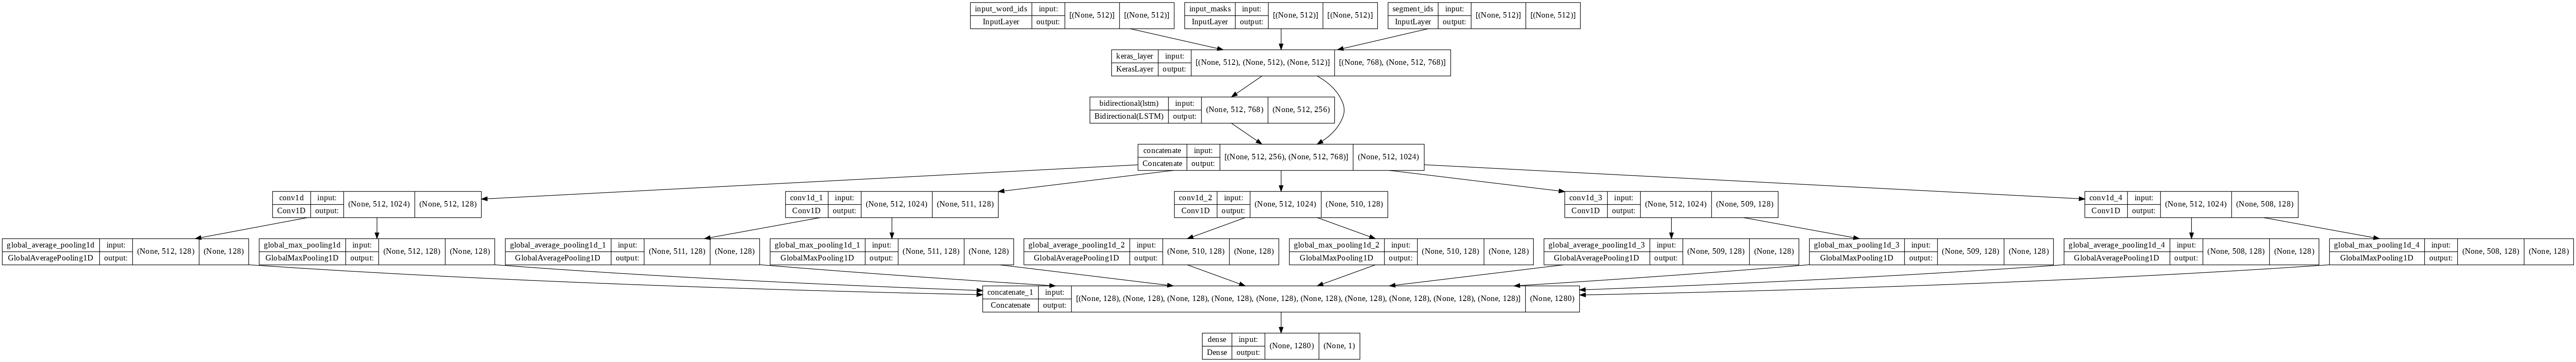

In [ ]:
tf.keras.utils.plot_model(
    Rcnn_variant,
    to_file="Variant_Rcnn.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=98,
   
    
)

In [ ]:
Rcnn_variant.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#csv_logger_VRcnn = callbacks.CSVLogger('Variant_Rcnn.log')
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_VRcnn = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/Variant_Rcnn.log')

In [ ]:
from time import time
start =time()

history = Rcnn_variant.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs =5 ,
          batch_size = 64,
          validation_split = 0.2,
          callbacks = [es,csv_logger_VRcnn]
          )

Epoch 1/5
449/449 [==============================] - 1668s 4s/step - loss: 0.0816 - accuracy: 0.9765 - val_loss: 0.0091 - val_accuracy: 0.9969
Epoch 2/5
449/449 [==============================] - 1637s 4s/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0025 - val_accuracy: 0.9993
Epoch 3/5
449/449 [==============================] - 1637s 4s/step - loss: 4.1597e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9996
Epoch 4/5
449/449 [==============================] - 1636s 4s/step - loss: 1.3988e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9996
Epoch 5/5
449/449 [==============================] - 1636s 4s/step - loss: 7.1143e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9996


In [ ]:
print(time()-start)

8213.338846683502


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/VariantRcnn.hdf5')
Rcnn_variant.save(model_path)

In [ ]:
from tensorflow import keras
my_reloaded_model_bert_Variantrcnn= tf.keras.models.load_model(
       ('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/VariantRcnn.hdf5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/models/modelspart2/Variant_RCNN_bert_part2.hdf5')

In [ ]:
my_reloaded_model_bert_Variantrcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
csv_logger_VRcnn = callbacks.CSVLogger('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/logs/RcnnVariant_v2.log')
checkpointer=tf.keras.callbacks.ModelCheckpoint(filepath=model_path,verbose=1,save_best_only=True)

In [ ]:
from time import time
start =time()

history = my_reloaded_model_bert_Variantrcnn.fit([train_inp, train_mask, train_segment], 
          train_label,
          epochs = 10,
          batch_size = 64,
          validation_split = 0.2,
          callbacks = [es,csv_logger_VRcnn,checkpointer]
          )

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9981
Epoch 1: val_loss improved from inf to 0.00149, saving model to /content/drive/MyDrive/BERT/models/modelspart2/Variant_RCNN_bert_part2.hdf5
449/449 [==============================] - 1746s 4s/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0015 - val_accuracy: 0.9997
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 6.1561e-04 - accuracy: 0.9998
Epoch 2: val_loss did not improve from 0.00149
449/449 [==============================] - 1715s 4s/step - loss: 6.1561e-04 - accuracy: 0.9998 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 9.6696e-05 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.00149 to 0.00114, saving model to /content/drive/MyDrive/BERT/models/modelspart2/Variant_RCNN_bert_part2.hdf5
449/449 [==============================] - 1716s 4s/step - loss: 9.6696e-05 - accuracy: 1.0000 - val_lo

In [ ]:
my_reloaded_model_bert_Variantrcnn.evaluate([val_inp, val_mask, val_segment],
               val_label, 
               batch_size =1)

8980/8980 [==============================] - 581s 64ms/step - loss: 7.5000e-04 - accuracy: 0.9997


[0.0007500025094486773, 0.9996659159660339]

In [ ]:
print(time()-start)

11560.451241016388


In [ ]:
model_path=('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/modelpart2/Variant_RCNN_bert_part2.hdf5')
my_reloaded_model_bert_Variantrcnn.save(model_path)

In [ ]:
y_pred_VarRcnn =np.round(my_reloaded_model_bert_Variantrcnn.predict([val_inp, val_mask, val_segment])) 

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
print(precision_score(val_label,y_pred_VarRcnn))
print(recall_score(val_label,y_pred_VarRcnn))
print(f1_score(val_label,y_pred_VarRcnn))

1.0
0.9993116108306562
0.9996556869046253


In [ ]:
print(classification_report(val_label, y_pred_VarRcnn, labels=[0,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4622
           1       1.00      1.00      1.00      4358

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
matplotlib.rcParams.update({'font.size': 16})
labels = [0,1]
Cnn_lstm = confusion_matrix(val_label,y_pred_VarRcnn,labels=labels)

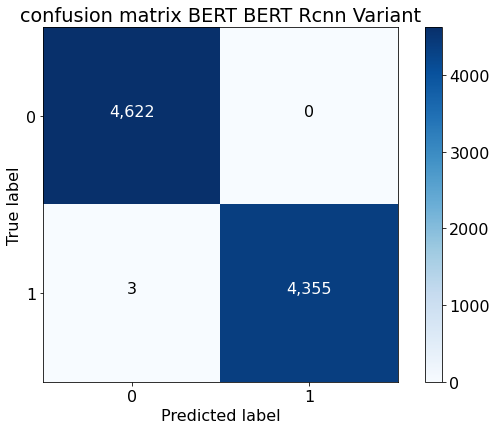

In [ ]:
plot_confusion_matrix(Cnn_lstm,title='confusion matrix BERT BERT Rcnn Variant',normalize=False,target_names=labels,path_file='/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/weights models'+'Cnn_lstm_vreview_cm.svg')

In [ ]:
df_model_Variant_Rcnn = pd.read_csv('/content/drive/MyDrive/PFE_ZHOUR_RHRISSI/Fake_news_detection/log_file/Variant_Rcnn.log')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_Variant_Rcnn['epoch'], y=df_model_Variant_Rcnn['accuracy'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_Variant_Rcnn['epoch'], y=df_model_Variant_Rcnn['val_accuracy'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [ ]:
# Training and Test loss
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_model_Variant_Rcnn['epoch'], y=df_model_Variant_Rcnn['loss'],
                    mode='lines',
                    name='training'))

fig.add_trace(go.Scatter(x=df_model_Variant_Rcnn['epoch'], y=df_model_Variant_Rcnn['val_loss'],
                    mode='lines',
                    name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')